In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.constants as sp_const
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

from pmd_beamphysics.wavefront import Wavefront, WavefrontParams

## Params dict

In [2]:
zR = 2.0
params = WavefrontParams(
    lambda0=1.35e-8,
    half_size=3e-4,
    tmax=50,
    tgrid=801,
    xgrid=101,
    ygrid=101,
    tpad=40,
    xpad=100,
    ypad=100,
)

In [3]:
params

WavefrontParams(lambda0=1.35e-08, half_size=0.0003, tmax=50.0, tgrid=801, xgrid=101, ygrid=101, tpad=45, xpad=107, ypad=107)

## Creating a Wavefront

In [4]:
X = Wavefront(
    params.create_gaussian_pulse_3d_with_q(zR=zR, nphotons=1e12, sigma_t=5),
    params=params,
    # tgrid=801,
)

In [5]:
nt, nx, ny = np.shape(X.field_rspace)

In [6]:
print(X.field_rspace.shape)

(801, 101, 101)


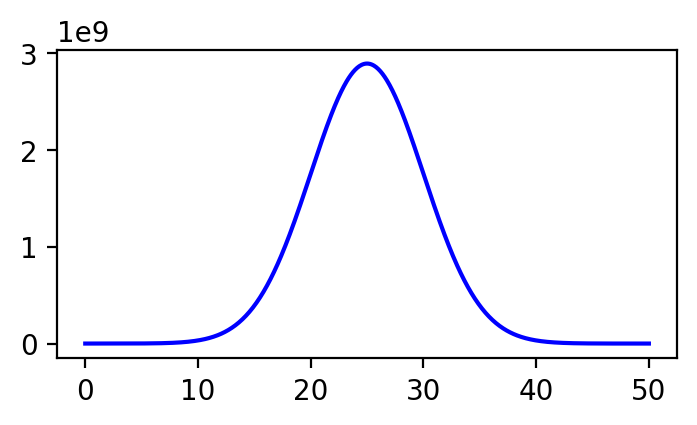

In [7]:
plt.figure(figsize=(4, 2))
plt.plot(X.params.domains_txy[0], np.abs(X.field_rspace[:, int(nx / 2), int(ny / 2)]), color="b");

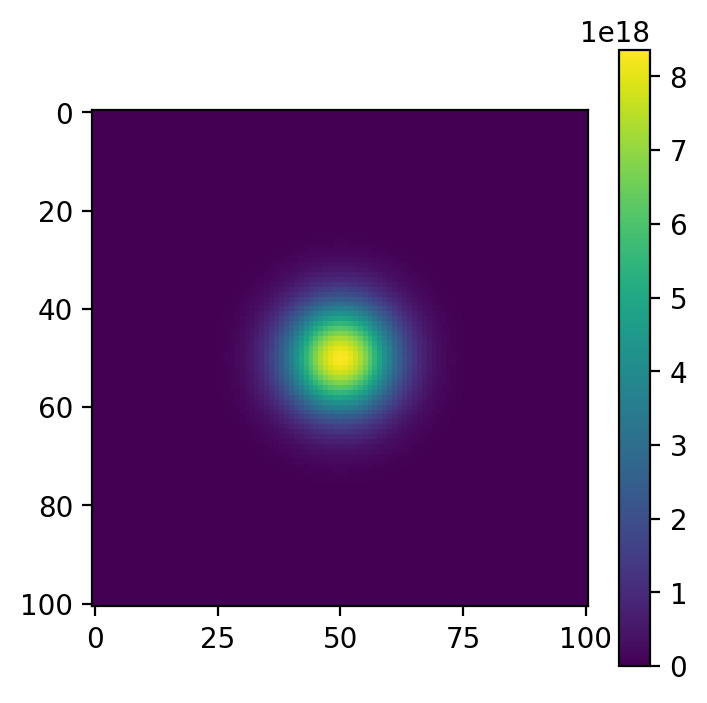

In [8]:
plt.figure(figsize=(4, 4))
plt.imshow(np.abs(X.field_rspace[int(nt / 2), :, :]) ** 2)
plt.colorbar();

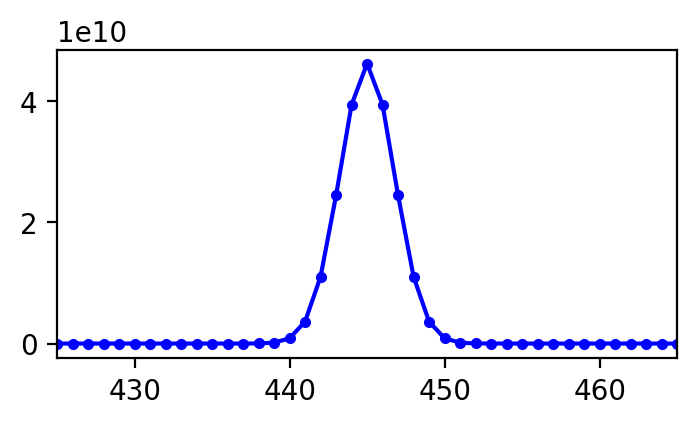

In [9]:
nw, nkx, nky = X.field_kspace.shape
plt.figure(figsize=(4, 2))
kspace_slice = np.abs(X.field_kspace[:, int(nkx / 2), int(nky / 2)])
plt.plot(kspace_slice, ".-", color="b")
peak_x = np.argmax(kspace_slice)
plt.xlim(peak_x - 20, peak_x + 20);

(132.0, 182.0)

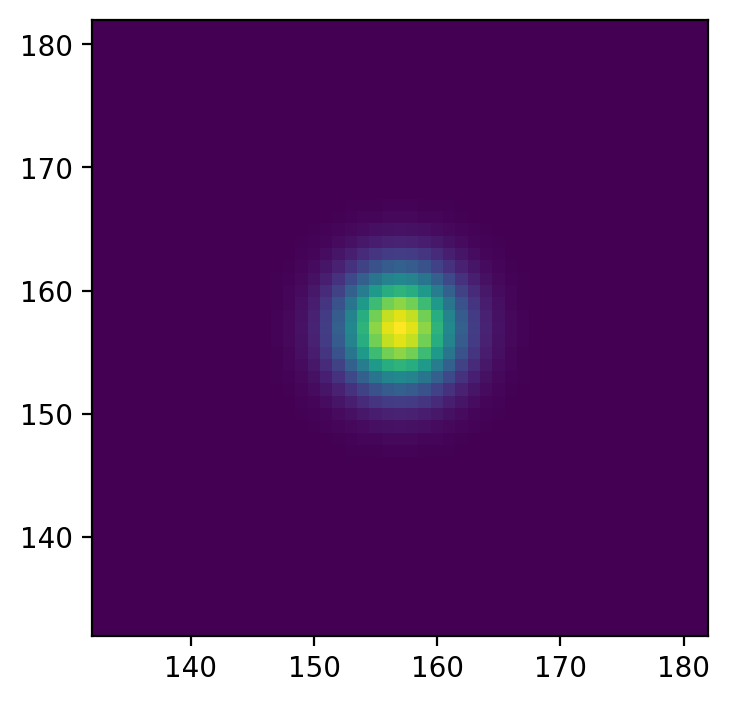

In [10]:
plt.figure(figsize=(4, 4))
kspace_image = np.abs(X.field_kspace[int(nw/2), :, :])**2

center = np.argmax(kspace_image, axis=0)[0]
plt.imshow(kspace_image)
plt.xlim(center - 25, center + 25)
plt.ylim(center - 25, center + 25)

## Propagation

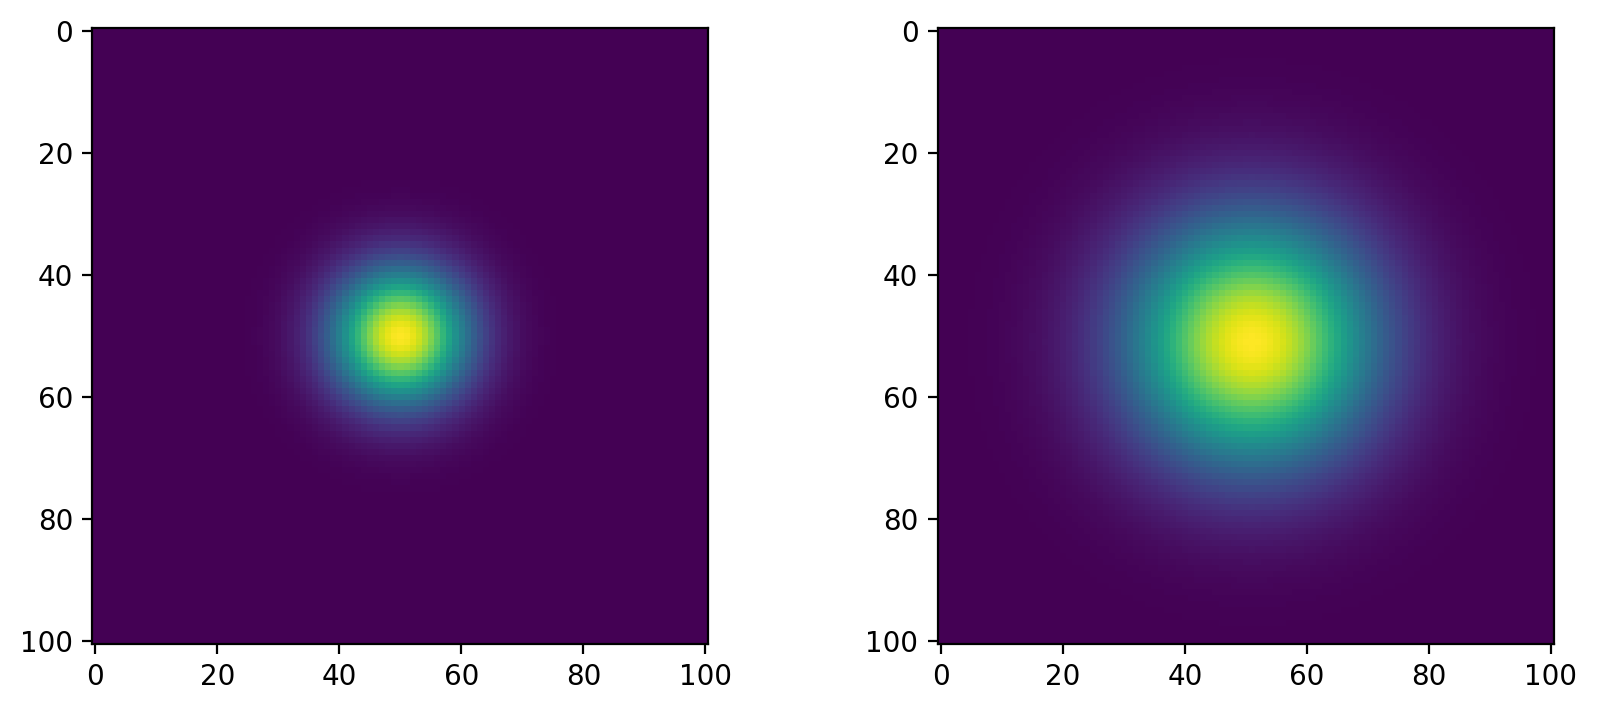

In [11]:
X = Wavefront(
    params.create_gaussian_pulse_3d_with_q(zR=zR, nphotons=1e12, sigma_t=5),
    params=params,
)

old = X.field_rspace
X.propagate_z(3)
new = X.field_rspace
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.imshow(np.abs(old[int(nt / 2), :, :]) ** 2)
ax2.imshow(np.abs(new[int(nt / 2), :, :]) ** 2);

In [12]:
def gaussian_func(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / 2.0 / c**2) + d

def gaussian_fit(xdata, ydata, initial_guess):
    popt_gaussian, pcov_gaussian = curve_fit(gaussian_func, xdata, ydata, p0=initial_guess)
    FWHM = popt_gaussian[2] * 2.355

    ydata_fit = gaussian_func(xdata, *popt_gaussian)
    
    spline = UnivariateSpline(xdata, ydata_fit - np.max(ydata_fit) / 2.0, s=0)
    r1, r2 = spline.roots()

    roots = [r1, r2]

    return popt_gaussian, ydata_fit, FWHM, roots

In [13]:
X = Wavefront(
    params.create_gaussian_pulse_3d_with_q(zR=zR, nphotons=1e12, sigma_t=5),
    params=params,
)

mz = 3
zgrid = 5
dz = 0.25

wfz = np.zeros((mz * zgrid, X.params.xgrid, X.params.ygrid))
fwhmz_fit = np.zeros(mz * zgrid)

w0 = np.sqrt(zR * X.params.lambda0 / np.pi)
z = np.linspace(
    -mz * zgrid * dz,
    mz * zgrid * dz + dz,
    2 * mz * zgrid + 1,
    endpoint=False,
)
wz = w0 * np.sqrt(1 + (z / zR) ** 2)

domain_x = X.params.domains_txy[1]

X.propagate_z(0.0)

for zi in range(0, mz * zgrid):
    if zi > 0:
        print("Propagating to: ", zi * dz)
        X.propagate_z(dz)
    wf = np.abs(X.field_rspace[int(nt / 2), :, :]) ** 2
    
    popt_gaussian, ydata_fit, FWHM, roots = gaussian_fit(
        domain_x,
        np.sum(wf, axis=1),
        [8e19, 0.0, 0.0002, 0.0],
    )
    wfz[zi, :, :] = wf.copy()
    fwhmz_fit[zi] = FWHM

wfz_wx = np.sum(wfz, axis=1)
wfz_wx2 = np.vstack((np.flip(wfz_wx, axis=0), wfz_wx))

/var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/ipykernel_96393/3266762373.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_gaussian, pcov_gaussian = curve_fit(gaussian_func, xdata, ydata, p0=initial_guess)


Propagating to:  0.25
Propagating to:  0.5
Propagating to:  0.75
Propagating to:  1.0
Propagating to:  1.25
Propagating to:  1.5
Propagating to:  1.75
Propagating to:  2.0
Propagating to:  2.25
Propagating to:  2.5
Propagating to:  2.75
Propagating to:  3.0
Propagating to:  3.25
Propagating to:  3.5


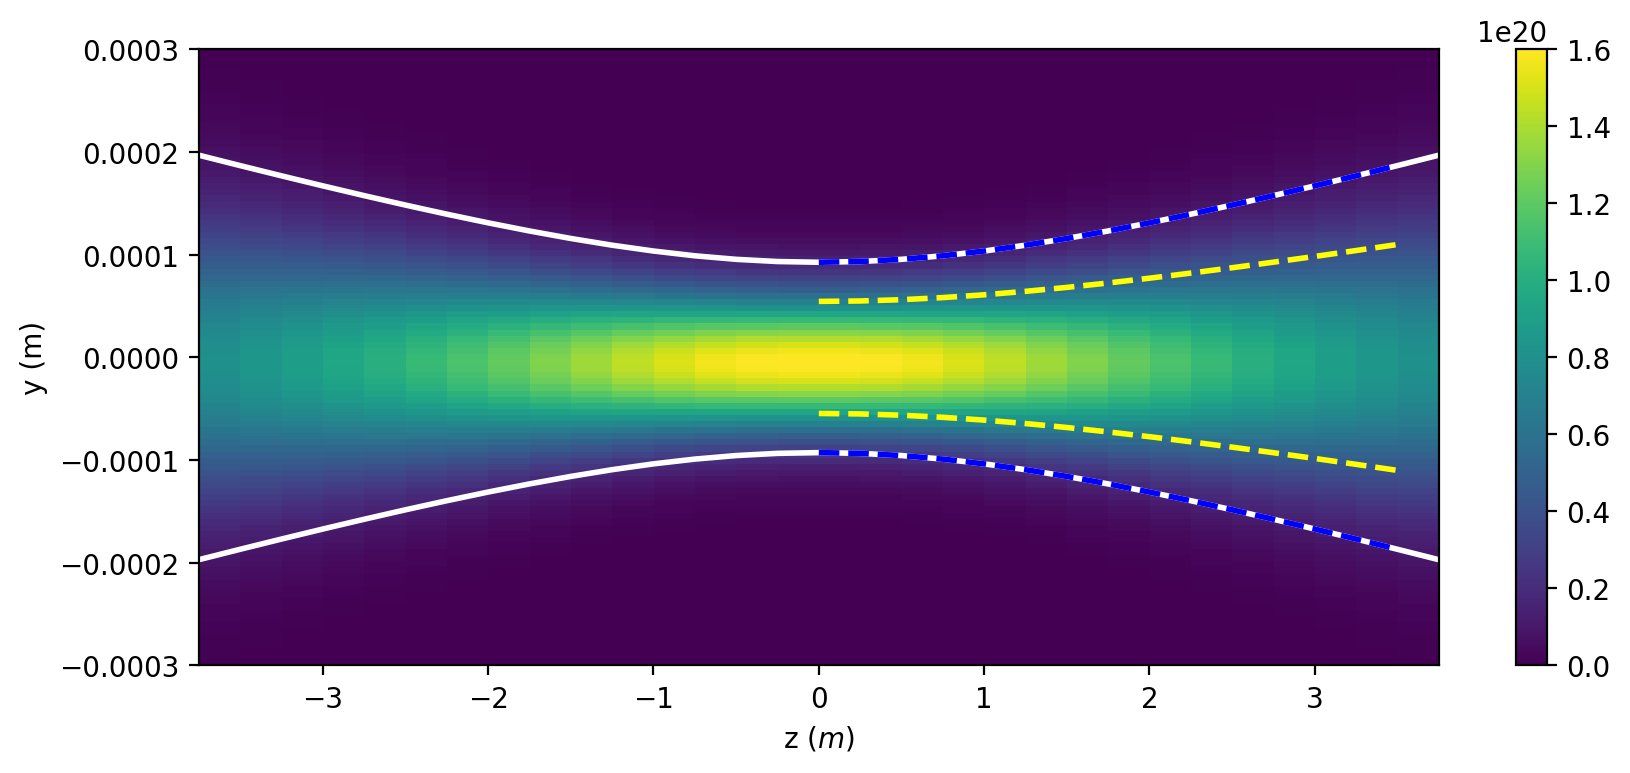

In [14]:
plt.figure(figsize=(10, 4))

plt.imshow(
    wfz_wx2.T,
    extent=[-mz * zgrid * dz, mz * zgrid * dz, -X.params.ymax, X.params.ymax],
    aspect="auto",
    vmin=0.0, vmax=1.6e20,
)

plt.plot(z, wz, "-", linewidth=2, color="white")
plt.plot(z, -wz, "-", linewidth=2, color="white")

plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    fwhmz_fit / np.sqrt(2.0 * np.log(2)),
    "--",
    linewidth=2,
    color="blue",
)
plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    -fwhmz_fit / np.sqrt(2.0 * np.log(2)),
    "--",
    linewidth=2,
    color="blue",
)

plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    fwhmz_fit / 2,
    "--",
    linewidth=2,
    color="yellow",
)
plt.plot(
    z[int(mz * zgrid) : int(2 * mz * zgrid)],
    -fwhmz_fit / 2,
    "--",
    linewidth=2,
    color="yellow",
)


plt.ylim(-X.params.ymax, X.params.ymax)

plt.xlabel(r"z ($m$)")
plt.ylabel("y (m)")
plt.colorbar();